<a href="https://colab.research.google.com/github/Kunalzzxx/fake-news-detection/blob/main/fake_news_detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Evaluating Logistic Regression
Accuracy: 0.9922893752126092
Precision: 0.9922893752126092
Recall: 0.9922893752126092
F1 Score: 0.9922893752126092
ROC AUC: 0.9980469434380097
Evaluating Random Forest
Accuracy: 0.989341195146842
Precision: 0.9893636305438329
Recall: 0.989341195146842
F1 Score: 0.9893393534621924
ROC AUC: 0.999308753551949
Evaluating Naive Bayes
Accuracy: 0.962240616849983
Precision: 0.9623274001894493
Recall: 0.962240616849983
F1 Score: 0.9622492234559108
ROC AUC: 0.5042867637268164
Evaluating Gradient Boosting
Accuracy: 0.9988660845900896
Precision: 0.9988685426768225
Recall: 0.9988660845900895
F1 Score: 0.9988660265920304
ROC AUC: 0.9999883800310085
Evaluating Logistic Regression for Regression Metrics
RMSE: 0.0878
MSE: 0.0077
MAE: 0.0077
R-squared: 0.9691
Evaluating Random Forest for Regression Metrics
RMSE: 0.1032
MSE: 0.0107
MAE: 0.0107
R-squared: 0.9573
Evaluating Naive Bayes for Regression Metrics
RMSE: 0.1943
MSE: 0.0378
MAE: 0.0378
R-squared: 0.8487
Evaluating G

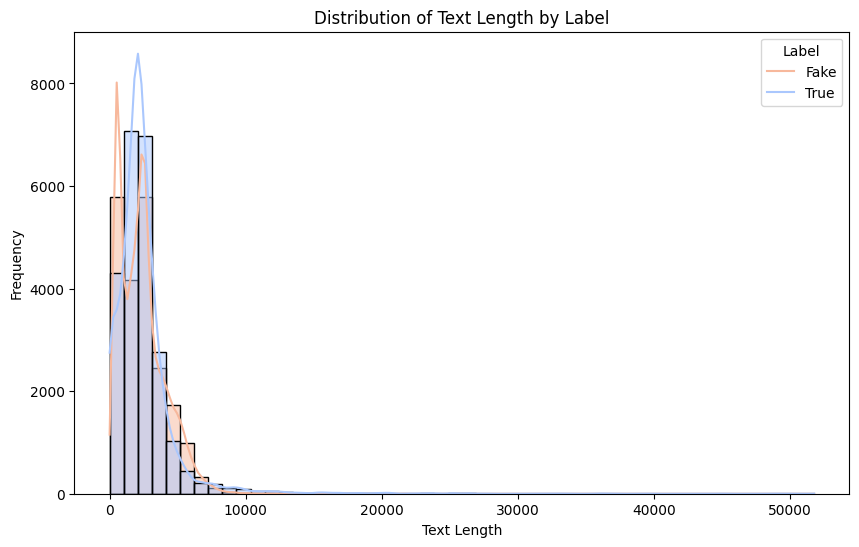

<ipython-input-1-8320d70d6d4c>:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=class_counts, x="label", y="count", palette="coolwarm")


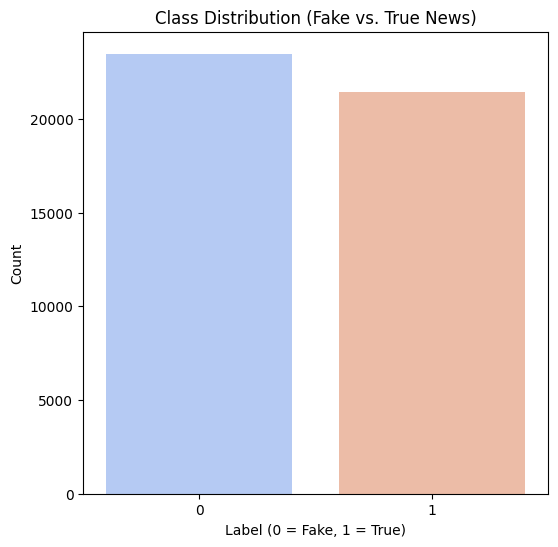

<ipython-input-1-8320d70d6d4c>:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=class_counts, x="label", y="count", palette="coolwarm")


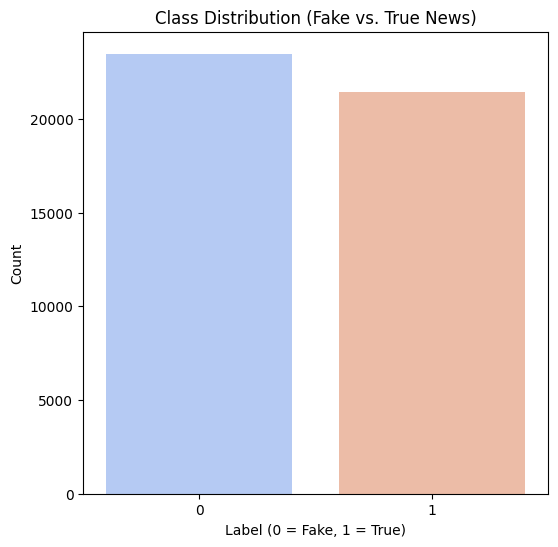

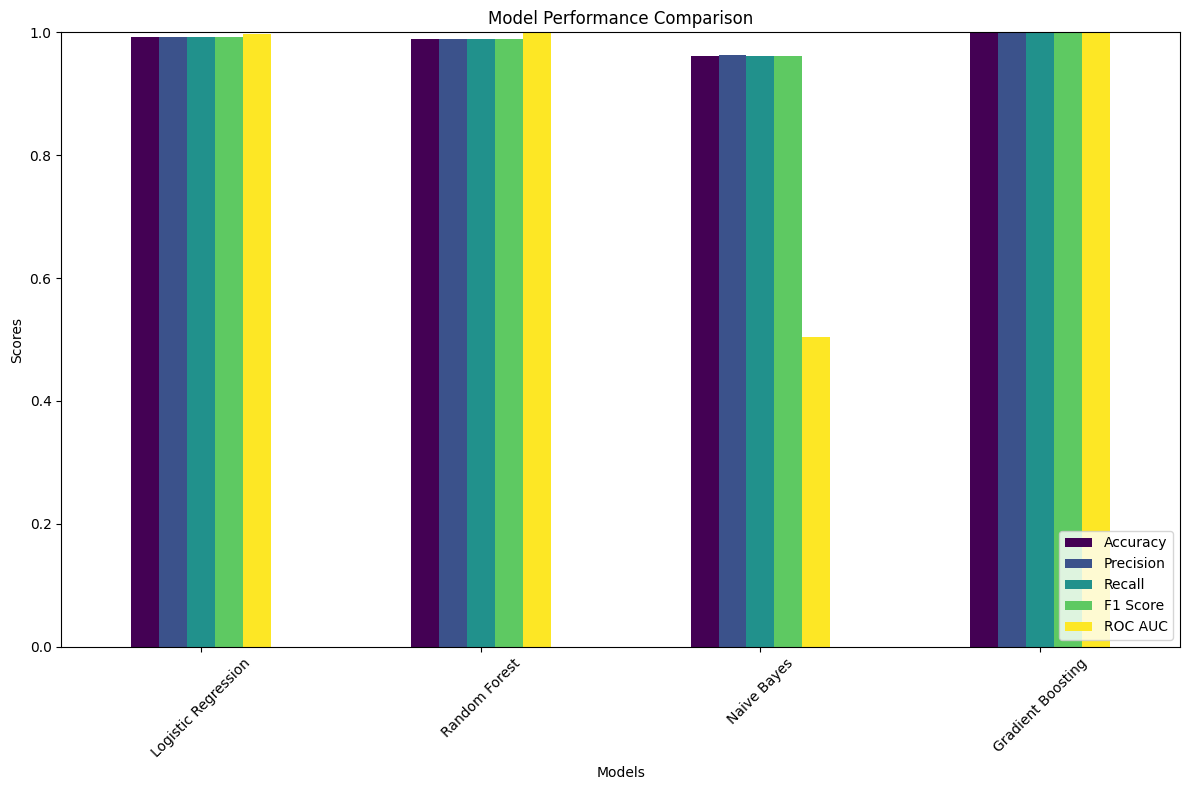

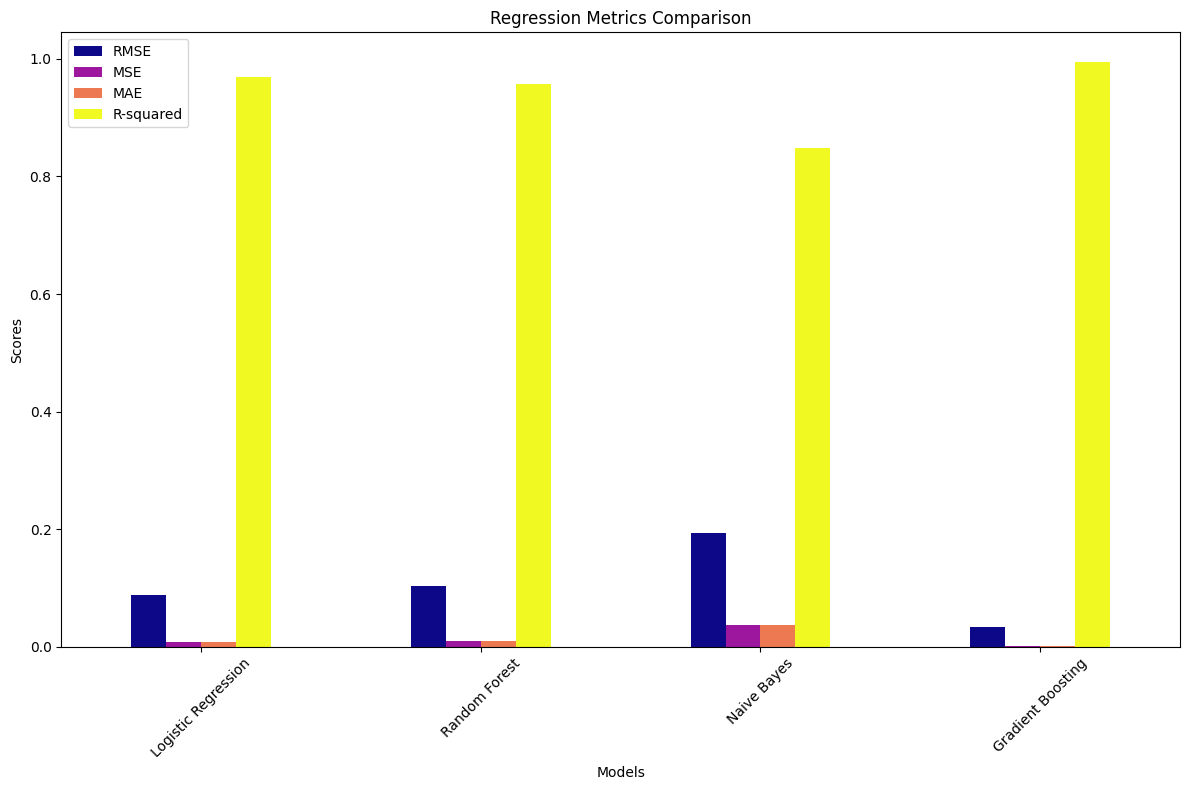

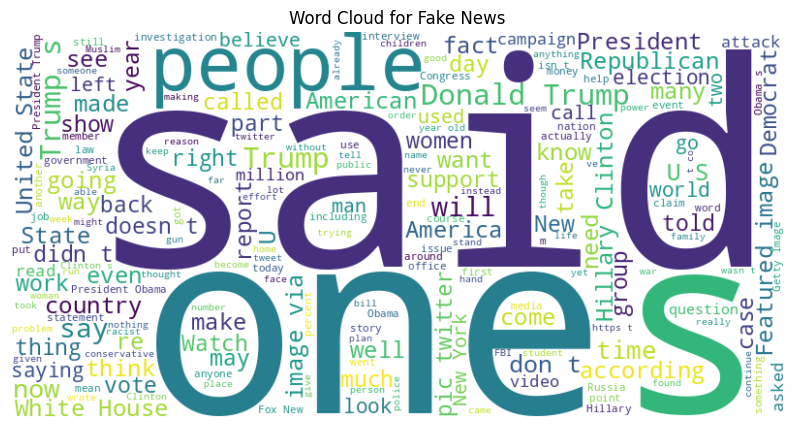

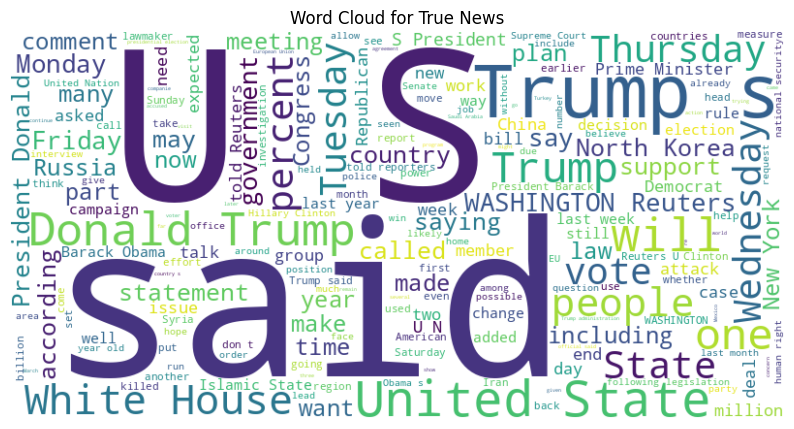

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, udf, length
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import numpy as np

# Create Spark Session
spark = SparkSession.builder \
    .appName("Fake News Detection") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()


# Load datasets
fake_df = spark.read.csv("/content/Fake.csv", header=True, inferSchema=True)
true_df = spark.read.csv("/content/True.csv", header=True, inferSchema=True)

# Add labels
fake_df = fake_df.withColumn("label", when(col("title").isNotNull(), 0))
true_df = true_df.withColumn("label", when(col("title").isNotNull(), 1))

# Combine datasets
data = fake_df.select("text", "label").union(true_df.select("text", "label"))

# Preprocessing
data = data.filter(data.text.isNotNull())  # Remove null rows
data = data.withColumn("text_length", length(col("text")))

# Tokenization and TF-IDF
tokenizer = Tokenizer(inputCol="text", outputCol="words")
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
hashing_tf = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=10000)
idf = IDF(inputCol="raw_features", outputCol="features")

# Split data
train, test = data.randomSplit([0.8, 0.2], seed=42)

# Initialize Models
logistic_regression = LogisticRegression(featuresCol="features", labelCol="label")
random_forest = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50)
naive_bayes = NaiveBayes(featuresCol="features", labelCol="label")
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=10)

# Pipelines
lr_pipeline = Pipeline(stages=[tokenizer, stopwords_remover, hashing_tf, idf, logistic_regression])
rf_pipeline = Pipeline(stages=[tokenizer, stopwords_remover, hashing_tf, idf, random_forest])
nb_pipeline = Pipeline(stages=[tokenizer, stopwords_remover, hashing_tf, idf, naive_bayes])
gbt_pipeline = Pipeline(stages=[tokenizer, stopwords_remover, hashing_tf, idf, gbt])

# Fit models
lr_model = lr_pipeline.fit(train)
rf_model = rf_pipeline.fit(train)
nb_model = nb_pipeline.fit(train)
gbt_model = gbt_pipeline.fit(train)

# Predictions
lr_preds = lr_model.transform(test)
rf_preds = rf_model.transform(test)
nb_preds = nb_model.transform(test)
gbt_preds = gbt_model.transform(test)

# Evaluators
binary_eval = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
multi_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

def evaluate(predictions, name):
    print(f"Evaluating {name}")
    accuracy = multi_eval.evaluate(predictions, {multi_eval.metricName: "accuracy"})
    precision = multi_eval.evaluate(predictions, {multi_eval.metricName: "weightedPrecision"})
    recall = multi_eval.evaluate(predictions, {multi_eval.metricName: "weightedRecall"})
    f1 = multi_eval.evaluate(predictions, {multi_eval.metricName: "f1"})
    roc = binary_eval.evaluate(predictions)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc}")
    return accuracy, precision, recall, f1, roc
reg_eval = RegressionEvaluator(labelCol="label", predictionCol="prediction")

def evaluate_regression(predictions, name):
    print(f"Evaluating {name} for Regression Metrics")
    rmse = reg_eval.evaluate(predictions, {reg_eval.metricName: "rmse"})
    mse = reg_eval.evaluate(predictions, {reg_eval.metricName: "mse"})
    mae = reg_eval.evaluate(predictions, {reg_eval.metricName: "mae"})
    r2 = reg_eval.evaluate(predictions, {reg_eval.metricName: "r2"})

    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R-squared: {r2:.4f}")
    return rmse, mse, mae, r2
# Evaluate all models
metrics = {}
metrics["Logistic Regression"] = evaluate(lr_preds, "Logistic Regression")
metrics["Random Forest"] = evaluate(rf_preds, "Random Forest")
metrics["Naive Bayes"] = evaluate(nb_preds, "Naive Bayes")
metrics["Gradient Boosting"] = evaluate(gbt_preds, "Gradient Boosting")

# Evaluate Regression Metrics
metrics_regression = {}
metrics_regression["Logistic Regression"] = evaluate_regression(lr_preds, "Logistic Regression")
metrics_regression["Random Forest"] = evaluate_regression(rf_preds, "Random Forest")
metrics_regression["Naive Bayes"] = evaluate_regression(nb_preds, "Naive Bayes")
metrics_regression["Gradient Boosting"] = evaluate_regression(gbt_preds, "Gradient Boosting")

# Print Regression Metrics
for model, metric in metrics_regression.items():
    print(f"\n{model} (Regression Metrics):")
    print(f"RMSE: {metric[0]:.4f}, MSE: {metric[1]:.4f}, MAE: {metric[2]:.4f}, R-squared: {metric[3]:.4f}")

# Print Final Metrics
for model, metric in metrics.items():
    print(f"\n{model}:")
    print(f"Accuracy: {metric[0]:.4f}, Precision: {metric[1]:.4f}, Recall: {metric[2]:.4f}, F1-Score: {metric[3]:.4f}, ROC AUC: {metric[4]:.4f}")


# Plot Text Length Distribution
data_pd = data.select("text_length", "label").toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(data=data_pd, x="text_length", hue="label", kde=True, bins=50, palette="coolwarm")
plt.title("Distribution of Text Length by Label")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.legend(title="Label", labels=["Fake", "True"])
plt.show()

# Class Distribution
class_counts = data.groupBy("label").count().toPandas()

# Plot Class Distribution
plt.figure(figsize=(6, 6))
sns.barplot(data=class_counts, x="label", y="count", palette="coolwarm")
plt.title("Class Distribution (Fake vs. True News)")
plt.xlabel("Label (0 = Fake, 1 = True)")
plt.ylabel("Count")
plt.show()


# Class Distribution
class_counts = data.groupBy("label").count().toPandas()

# Plot Class Distribution
plt.figure(figsize=(6, 6))
sns.barplot(data=class_counts, x="label", y="count", palette="coolwarm")
plt.title("Class Distribution (Fake vs. True News)")
plt.xlabel("Label (0 = Fake, 1 = True)")
plt.ylabel("Count")
plt.show()


# Prepare Data for Visualization
metrics_df = pd.DataFrame.from_dict(metrics, orient="index", columns=["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"])

# Bar Plot for Metrics
metrics_df.plot(kind="bar", figsize=(12, 8), colormap="viridis")
plt.title("Model Performance Comparison")
plt.xlabel("Models")
plt.ylabel("Scores")
plt.ylim(0, 1)  # All metrics range from 0 to 1
plt.legend(loc="lower right")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Prepare Data for Visualization
reg_metrics_df = pd.DataFrame.from_dict(metrics_regression, orient="index", columns=["RMSE", "MSE", "MAE", "R-squared"])

# Bar Plot for Regression Metrics
reg_metrics_df.plot(kind="bar", figsize=(12, 8), colormap="plasma")
plt.title("Regression Metrics Comparison")
plt.xlabel("Models")
plt.ylabel("Scores")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


from wordcloud import WordCloud

# Generate Word Cloud for Fake News
data_pd = data.select("text", "label").toPandas()
fake_text = " ".join(data_pd[data_pd["label"] == 0]["text"].dropna())
fake_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(fake_text)

plt.figure(figsize=(10, 6))
plt.imshow(fake_wordcloud, interpolation="bilinear")
plt.title("Word Cloud for Fake News")
plt.axis("off")
plt.show()

# Generate Word Cloud for True News
true_text = " ".join(data_pd[data_pd["label"] == 1]["text"].dropna())
true_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(true_text)

plt.figure(figsize=(10, 6))
plt.imshow(true_wordcloud, interpolation="bilinear")
plt.title("Word Cloud for True News")
plt.axis("off")
plt.show()